# Analysis of our Network

In [1]:
# import libraries
import collections
import datetime
import json
import matplotlib.pyplot as plt
import networkx as nx
import networkx.algorithms.community as nxcom
import numpy as np
import os
import rasterio
from rasterio.mask import mask
from shapely import wkt
from shapely.plotting import patch_from_polygon

In [2]:
# path to gml file
nx_ntl = nx.read_gml('county_graph_with_ntl.gml')

def normalize_weights(graph, date_str):
    """this function normalizes the weights"""
    # calculate the average ntl_sum for each edge
    for u, v in graph.edges():
        ntl_u = json.loads(graph.nodes[u]['ntl'])
        ntl_v = json.loads(graph.nodes[v]['ntl'])
        
        # calculate the average ntl_sum for the two nodes
        avg_ntl_sum = (ntl_u[date_str][f'{date_str}_avg'] + ntl_v[date_str][f'{date_str}_avg']) / 2
        
        # assign the average ntl_sum as the weight of the edge
        graph[u][v]['weight'] = avg_ntl_sum
    
    # normalize the weights between 0 and 1
    weights = [graph[u][v]['weight'] for u, v in graph.edges()]
    min_weight = min(weights)
    max_weight = max(weights)
    
    for u, v in graph.edges():
        graph[u][v]['weight'] = 1 - ((graph[u][v]['weight'] - min_weight) / (max_weight - min_weight))

# apply the function to the graph on the 25.09.24
normalize_weights(nx_ntl, '2024-09-25')

# convert the "geometry" from WKT string back to Shapely geometry 
# and "ntl" from JSON string back to dictionary
for node, data in nx_ntl.nodes(data=True):
    if 'geometry' in data:
        data['geometry'] = wkt.loads(data['geometry'])
    if 'ntl' in data:
        data['ntl'] = json.loads(data['ntl'])

# print to check
first_node = list(nx_ntl.nodes(data=True))[0]
print(first_node)

('Georgia_Appling', {'state': 'Georgia', 'county': 'Appling', 'geometry': <MULTIPOLYGON (((-82.227 31.531, -82.228 31.532, -82.228 31.533, -82.229 31....>, 'ntl': {'2023-09-01': {'2023-09-01_sum': 55178.0, '2023-09-01_avg': 3.8318055555555555}, '2023-09-02': {'2023-09-02_sum': 43314.0, '2023-09-02_avg': 3.0079166666666666}, '2023-09-03': {'2023-09-03_sum': 50646.0, '2023-09-03_avg': 3.5170833333333333}, '2023-09-04': {'2023-09-04_sum': 81750.0, '2023-09-04_avg': 5.677083333333333}, '2023-09-05': {'2023-09-05_sum': 54391.0, '2023-09-05_avg': 3.777152777777778}, '2023-09-06': {'2023-09-06_sum': 55446.0, '2023-09-06_avg': 3.850416666666667}, '2023-09-07': {'2023-09-07_sum': 59246.0, '2023-09-07_avg': 4.114305555555555}, '2023-09-08': {'2023-09-08_sum': 59283.0, '2023-09-08_avg': 4.116875}, '2023-09-09': {'2023-09-09_sum': 80733.0, '2023-09-09_avg': 5.606458333333333}, '2023-09-10': {'2023-09-10_sum': 77241.0, '2023-09-10_avg': 5.363958333333334}, '2023-09-11': {'2023-09-11_sum': 71635.0, 

In [3]:
print(nx_ntl)

Graph with 205 nodes and 567 edges


In [4]:
# draw the graph
os.makedirs("visualizations", exist_ok=True)

# define the graph layout
pos = nx.spring_layout(nx_ntl, seed=39)

# dlot the graph with weights
plt.figure(figsize=(35, 25))

# extract the weights to use as edge thickness
weights = [nx_ntl[u][v]['weight'] for u, v in nx_ntl.edges()]

# draw the graph with edge weights affecting edge thickness
nx.draw(
    nx_ntl, pos, 
    with_labels=True, 
    node_size=50, 
    font_size=10, 
    edge_color="gray", 
    node_color="indianred",
    width=weights  # adjust edge width based on weight
)

plt.title("Graph Visualization with Edge Weights")
plt.savefig('visualizations/graph_visualization_with_weights.png', dpi=300, bbox_inches='tight')
plt.show()


# Nearest Neighbor Analysis

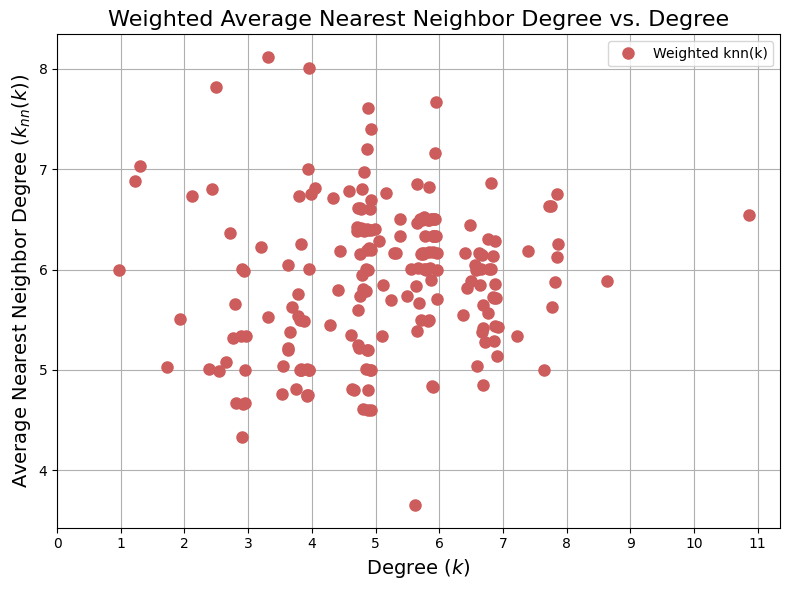

In [5]:
# calculate the weighted degree of each node (sum of edge weights)
node_degrees = dict(nx.degree(nx_ntl, weight='weight'))

# compute the weighted average neighbor degree of each node
avg_neighbor_degree = nx.average_neighbor_degree(nx_ntl, weight='weight')

# group by degree to compute knn(k) as a function of degree
degree_knn = {}
for node, degree in node_degrees.items():
    # get average neighbor degree for each node
    avg_deg = avg_neighbor_degree[node]
    
    # add average neighbor degree to the correct degree group
    if degree not in degree_knn:
        degree_knn[degree] = []
    degree_knn[degree].append(avg_deg)

# calculate the average knn(k) for each degree
degrees = sorted(degree_knn.keys())
knn_values = [np.mean(degree_knn[degree]) for degree in degrees]

# create plot
plt.figure(figsize=(8, 6))
plt.plot(degrees, knn_values, 'o', color='indianred', label="Weighted knn(k)", markersize=8)
plt.xlabel("Degree ($k$)", fontsize=14)
plt.ylabel("Average Nearest Neighbor Degree ($k_{nn}(k)$)", fontsize=14)
plt.title("Weighted Average Nearest Neighbor Degree vs. Degree", fontsize=16)
# show all degree values on x-axis
plt.xticks(range(12))  
plt.grid(True)
plt.legend(loc='best')
plt.tight_layout()
plt.show()


This plot examines the relationship between node degree (k) and the weighted average nearest neighbor degree (knn(k)) in a network of Georgia's counties, where edges represent shared borders and are weighted by the average NTL values of connected counties. The absence of a strong trend suggests a weak assortativity, meaning high-degree counties do not exclusively connect to other high-degree counties. The variability in knn(k) for low-degree nodes indicates that less-connected counties interact with both sparsely and densely connected neighbors, likely reflecting a mix of urban hubs and rural peripheries. For higher-degree nodes,knn(k) stabilizes, implying that well-connected counties are linked to neighbors of relatively similar degree and development. This pattern reflects a balance between geographic constraints and socioeconomic factors, with NTL weights emphasizing developmental similarities in the network's connectivity. Overall, the network reveals both structural heterogeneity and regional clustering shaped by geography and development. **However**, since we are working with a geographic network, **these results should be interpreted with caution**, as the analysis may not be particularly meaningful when considering direct geographic neighbors.

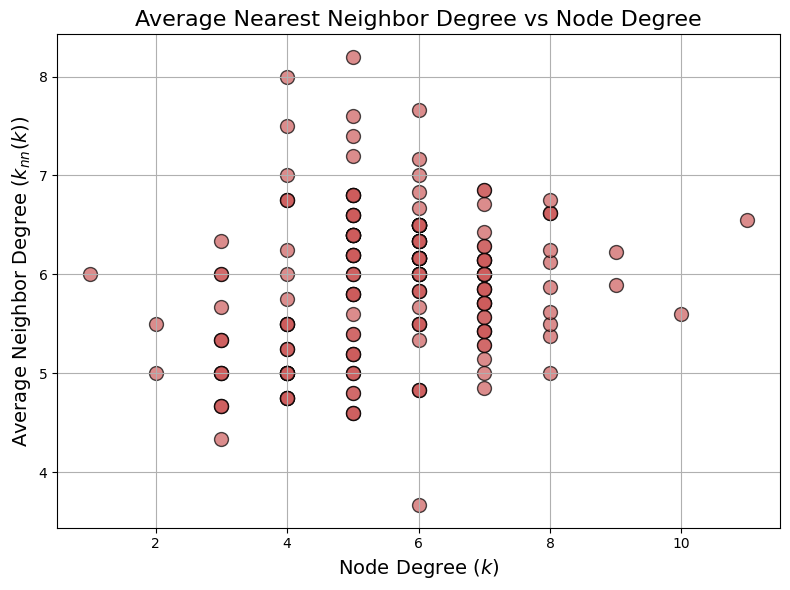

In [6]:
# calculate the degree of each node
node_degrees = dict(nx_ntl.degree())

# compute the average neighbor degree of each node
avg_neighbor_degree = nx.average_neighbor_degree(nx_ntl)

# group by degree to compute knn(k) as a function of degree
degree_knn = {}
for node, degree in node_degrees.items():
    if degree not in degree_knn:
        degree_knn[degree] = []
    degree_knn[degree].append(avg_neighbor_degree[node])

# calculate the average knn(k) for each degree
degrees = sorted(degree_knn.keys())
knn_values = [np.mean(degree_knn[degree]) for degree in degrees]

plt.figure(figsize=(8, 6))
plt.scatter(node_degrees.values(), list(avg_neighbor_degree.values()), color='indianred', alpha=0.7, edgecolors='k', s=100)
plt.xlabel("Node Degree ($k$)", fontsize=14)
plt.ylabel("Average Neighbor Degree ($k_{nn}(k)$)", fontsize=14)
plt.title("Average Nearest Neighbor Degree vs Node Degree", fontsize=16)
plt.grid(True)

plt.tight_layout()
plt.show()


This analysis aims to illustrate the structure of the network, specifically highlighting the number of direct neighbors each county has.

This plot shows the relationship between node degree (k) and the average nearest neighbor degree (knn(k)) in the Georgia county network, where edges represent shared borders, but without weighting by NTL. Unlike the previous weighted analysis, this unweighted version reflects purely the structural topology of the network. The clustering of knn(k) values around 5–7 across all degrees suggests a relatively homogeneous local connectivity, with high-degree nodes connecting to neighbors with a similar degree range. The lack of a strong upward or downward trend in knn(k) indicates weak or no assortative mixing, implying that counties with high connectivity are just as likely to connect to counties with low connectivity. This uniformity might be driven by geographic constraints, where adjacency between counties naturally limits degree variation. Overall, the network appears structurally balanced, with no pronounced hubs dominating its topology.

In [7]:
assortativity_coefficient = nx.degree_assortativity_coefficient(nx_ntl)

print(f"Assortativity Coefficient by Degree: {assortativity_coefficient:.4f}")

assortativity_coefficient_w = nx.degree_assortativity_coefficient(nx_ntl, weight='weight')

print(f"Weighted Assortativity Coefficient by Degree: {assortativity_coefficient_w:.4f}")


Assortativity Coefficient by Degree: 0.0744
Weighted Assortativity Coefficient by Degree: 0.1735


**Interpreting the assortativity coefficients of the degree is not meaningful, as they are influenced by geographic factors rather than network dynamics.**

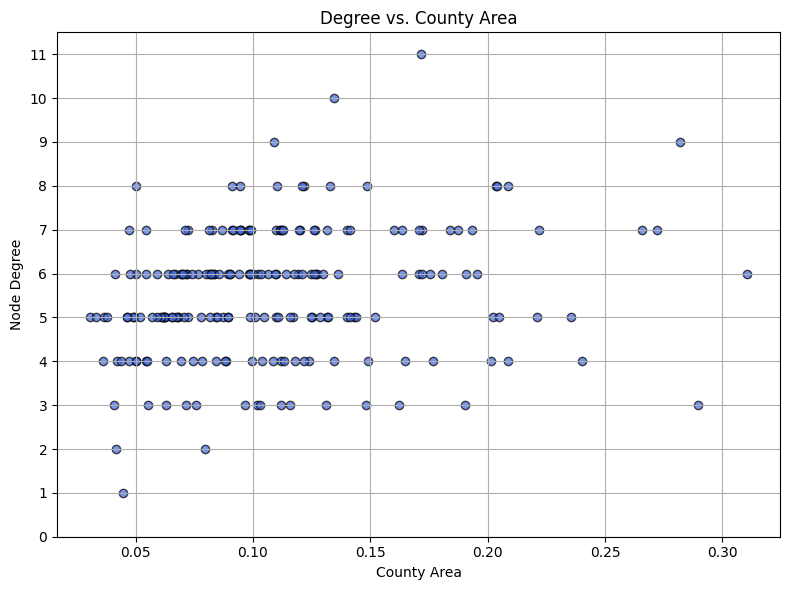

In [8]:
# extract areas of counties and degrees of nodes
areas = {data["state"]+"_"+data["county"]: data["geometry"].area for node, data in nx_ntl.nodes(data=True)}
degrees = dict(nx_ntl.degree())

# ensure nodes in areas and degrees match
common_nodes = set(areas.keys()) & set(degrees.keys())

# filter data to only include common nodes
areas_filtered = [areas[node] for node in common_nodes]
degrees_filtered = [degrees[node] for node in common_nodes]

# plot degree vs. area
plt.figure(figsize=(8, 6))
plt.scatter(areas_filtered, degrees_filtered, alpha=0.7, edgecolors='k', c='royalblue')

z = np.polyfit(areas_filtered, degrees_filtered, 1)
p = np.poly1d(z)

plt.title("Degree vs. County Area")
plt.xlabel("County Area")
plt.ylabel("Node Degree")
plt.yticks(range(12))
plt.grid(True)
plt.tight_layout()
plt.show()

The relationship between node degree and county area reveals insights into how geography influences the connectivity of counties within the network. Most counties having 4–6 neighbors suggests a consistent level of local connectivity, likely driven by the administrative and geographic organization of Georgia. However, the observation that larger counties tend to have fewer neighbors indicates an inverse relationship between area and degree. This pattern arises because larger counties typically occupy more space, reducing the number of bordering counties they can connect to. Smaller counties, by contrast, are often clustered in more densely subdivided regions, leading to higher degrees. This trend reflects the spatial constraints on the network's topology, where geographic size plays a key role in shaping the connectivity patterns. Such findings emphasize the balance between physical size and adjacency in determining the structural properties of the network. Also, we can see that there are more smaller counties in Georgia.


# Degree Probability Density in Logarithmic Scale

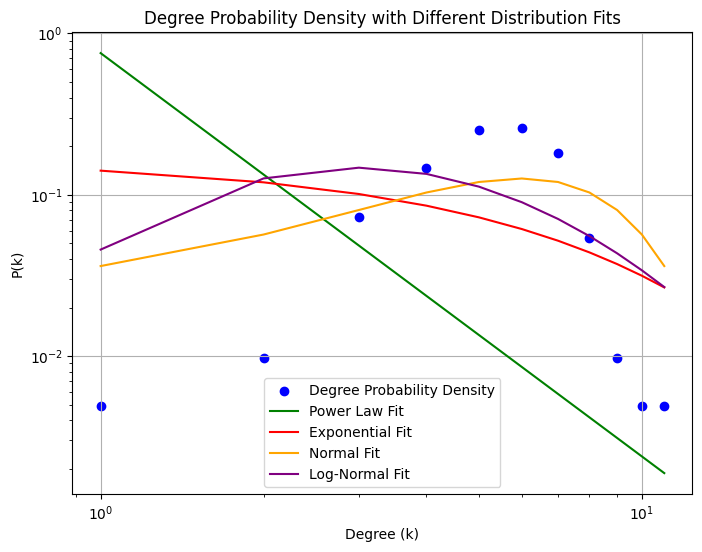

In [9]:
from scipy.stats import powerlaw, norm, lognorm, expon

# degree calculation and degree probability density
degrees = [d for n, d in nx_ntl.degree()]
degree_counts = np.bincount(degrees)
degree_prob = degree_counts / sum(degree_counts)

# plot degree distribution
plt.figure(figsize=(8, 6))
x = np.arange(len(degree_prob))[1:]  # exclude degree 0
y = degree_prob[1:]
plt.scatter(x, y, color='blue', label='Degree Probability Density')

# fit and plot Power Law
alpha = 2.5 # we used 2.5 as power law exponent
powerlaw_pdf = (alpha - 1) * (x) ** (-alpha)
plt.plot(x, powerlaw_pdf / sum(powerlaw_pdf), color='green', label='Power Law Fit')

# fit and plot Exponential Distribution
lambda_exp = 1 / np.mean(x)  # fit lambda based on the mean degree
exponential_pdf = expon.pdf(x, scale=1/lambda_exp)
plt.plot(x, exponential_pdf, color='red', label='Exponential Fit')

# fit and plot Normal Distribution
mean_deg = np.mean(x)
std_deg = np.std(x)
normal_pdf = norm.pdf(x, loc=mean_deg, scale=std_deg)
plt.plot(x, normal_pdf, color='orange', label='Normal Fit')

# fit and plot Log-Normal Distribution
shape, loc, scale = lognorm.fit(x, floc=0)  # fit log-normal to the data
lognormal_pdf = lognorm.pdf(x, shape, loc, scale)
plt.plot(x, lognormal_pdf, color='purple', label='Log-Normal Fit')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree (k)')
plt.ylabel('P(k)')
plt.title('Degree Probability Density with Different Distribution Fits')
plt.grid(True)
plt.legend()
plt.show()

As we can see, nothing really fits our data but that makes sense as we do not have these common network dynamics (geographic network).

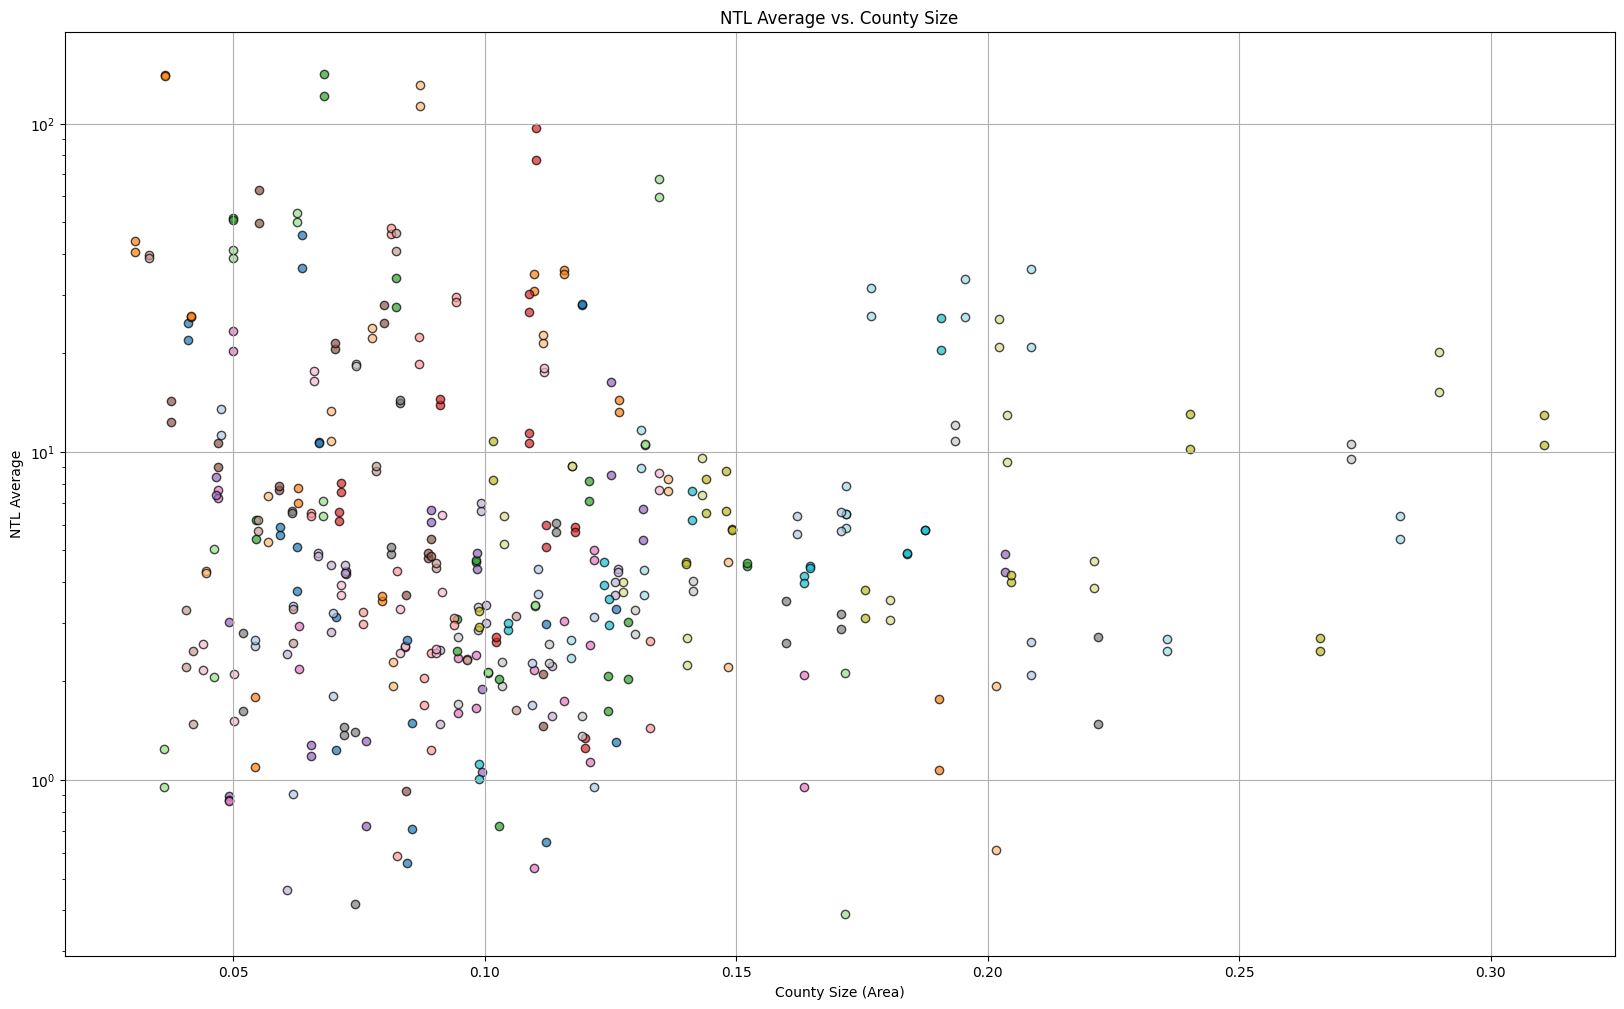

In [10]:
import matplotlib.cm as cm

# extract area and NTL average data
areas = {}
ntl_avgs = {}

# dates to use for NTL average
target_date_1 = '2024-09-25'
target_date_2 = '2024-09-30'

# use a colormap to color the points differently
cmap = plt.colormaps['tab20']

# dictionary to map each county to a unique color
county_colors = {}

for i, (node, data) in enumerate(nx_ntl.nodes(data=True)):
    # compute county area
    if "geometry" in data:
        try:
            # ensure geometry is a string before parsing
            geometry = wkt.loads(str(data["geometry"]))
            # ensure geometry is valid
            if geometry.is_valid:  
                # get the area of the geometry
                areas[node] = geometry.area  
            else:
                print(f"Invalid geometry for node {node}")
        except Exception as e:
            print(f"Error processing geometry for node {node}: {e}")
            continue
    
    # extract NTL average for the target dates
    if "ntl" in data:
        try:
            ntl_data = data["ntl"]
            
            # extract NTL averages for the specified dates
            ntl_avgs[node] = {
                target_date_1: ntl_data.get(target_date_1, {}).get(f"{target_date_1}_avg", 0),
                target_date_2: ntl_data.get(target_date_2, {}).get(f"{target_date_2}_avg", 0)
            }

            # assign a unique color for each county based on its index
            county_colors[node] = cmap(i / len(nx_ntl.nodes()))  # normalize the index for the colormap
        except Exception as e:
            print(f"Error processing NTL data for node {node}: {e}")

# ensure matched nodes for plotting
common_nodes = set(areas.keys()) & set(ntl_avgs.keys())
areas_filtered = [areas[node] for node in common_nodes]
ntl_avgs_filtered_1 = [ntl_avgs[node][target_date_1] for node in common_nodes]
ntl_avgs_filtered_2 = [ntl_avgs[node][target_date_2] for node in common_nodes]

# check if there is data to plot
if areas_filtered and ntl_avgs_filtered_1 and ntl_avgs_filtered_2:
    plt.figure(figsize=(20, 12))

    # plot NTL average vs. county size for both dates, using consistent colors for each county
    for i, node in enumerate(common_nodes):
        # get the color assigned to this county
        color = county_colors[node]  
        
        # plot for the first date
        plt.scatter(areas[node], ntl_avgs[node][target_date_1], alpha=0.7, edgecolors='k', c=[color])

        # plot for the second date
        plt.scatter(areas[node], ntl_avgs[node][target_date_2], alpha=0.7, edgecolors='k', c=[color])

    plt.title("NTL Average vs. County Size")
    plt.xlabel("County Size (Area)")
    plt.ylabel("NTL Average")
    # make it logscale
    plt.yscale("log")
    plt.grid(True)

    plt.show()

else:
    print("No data to plot. Ensure that there are matching areas and NTL data.")


The plot supports the assumption that larger counties tend to have smaller average NTL values compared to smaller counties, reflecting lower population density or economic activity in these areas (higher rurality). This pattern aligns with the expected relationship between county size and development intensity. However, the impact of the hurricane on average NTL values appears negligible in the data, as there is no clear visible difference between pre- and post-hurricane values. This suggests that either the hurricane's effects on NTL were minimal or that any changes were too subtle to be captured by the current analysis.

In [11]:
from scipy.stats import ttest_rel

# collect NTL averages for the two dates for common nodes
ntl_avgs_date1 = np.array([ntl_avgs[node][target_date_1] for node in common_nodes])
ntl_avgs_date2 = np.array([ntl_avgs[node][target_date_2] for node in common_nodes])

# perform a paired t-test
t_stat, p_value = ttest_rel(ntl_avgs_date1, ntl_avgs_date2)

print(f"Paired t-test results: t-statistic = {t_stat}, p-value = {p_value}")

# automatic interpretation the results for p = 0.05
if p_value < 0.05:
    print("The differences in NTL averages before and after the hurricane are statistically significant.")
else:
    print("The differences in NTL averages before and after the hurricane are not statistically significant.")


Paired t-test results: t-statistic = -1.2172594148251787, p-value = 0.22491177638690066
The differences in NTL averages before and after the hurricane are not statistically significant.


### Interpretation
Based on the paired t-test results, with a t-statistic of -1.22 and a p-value of 0.225, we can conclude that the differences in NTL averages before and after the hurricane are not statistically significant. The p-value is well above the typical threshold of 0.05, indicating that there is insufficient evidence to suggest that the hurricane had a meaningful impact on the NTL averages of the counties. Therefore, the analysis supports the observation that the NTL differences are negligible.

Correlation between NTL differences of neighboring counties in Georgia: 0.48082629330671645


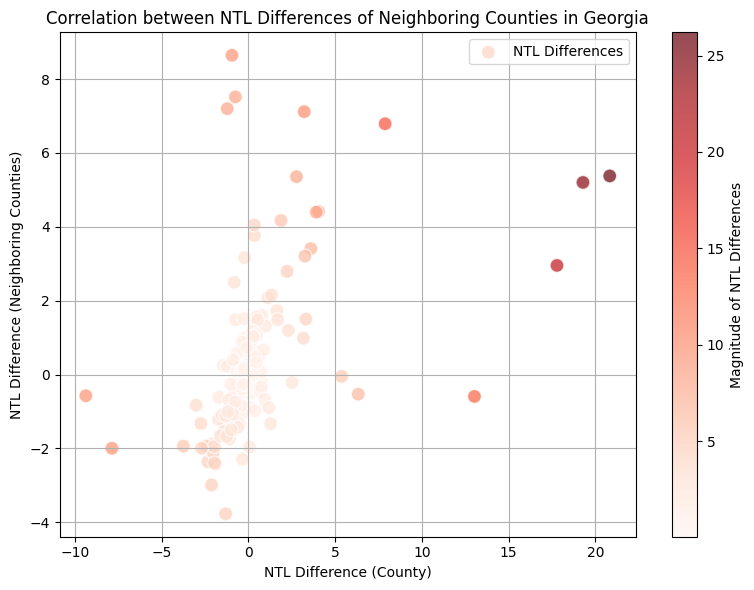

In [12]:
import ast
from shapely import wkt

# load the GML file
file_path = 'county_graph_with_ntl.gml'
nx_ntl = nx.read_gml(file_path)

# extract NTL Data for 2024-09-25 and 2024-09-30
target_dates = ['2024-09-25', '2024-09-30']
differences = {}

# extract county geometries and NTL average values for the two dates
for node, data in nx_ntl.nodes(data=True):
    geometry_wkt = data.get('geometry', None)
    ntl_data = data.get('ntl', None)
    
    if geometry_wkt and ntl_data:
        try:
            # parse the geometry
            geometry = wkt.loads(geometry_wkt)
            
            # convert NTL data to dictionary safely and calculate the difference
            ntl_dict = ast.literal_eval(ntl_data)  # safely evaluate string dictionary
            before = ntl_dict.get(target_dates[0], {}).get(f"{target_dates[0]}_avg", 0)
            after = ntl_dict.get(target_dates[1], {}).get(f"{target_dates[1]}_avg", 0)
            difference = after - before
            differences[node] = difference
        except Exception as e:
            print(f"Error processing node {node}: {e}")

# filter for counties in Georgia
georgia_counties = [node for node, data in nx_ntl.nodes(data=True) if 'Georgia' in node]

# calculate the NTL differences for neighboring counties
correlations = []
for county in georgia_counties:
    # get neighbors of the county as a list
    neighbors = list(nx_ntl.neighbors(county))
   
    n_diff = []
    for neighbor in neighbors:
        # ensure the neighbor is also in Georgia
        if neighbor in georgia_counties:  
            # get the difference between the dates of the county
            county_diff = differences.get(county, 0)
            # as well as from the neighbor
            neighbor_diff = differences.get(neighbor, 0)
            n_diff.append(neighbor_diff)
    
    # calculate average NTL difference of neighbors
    if n_diff:
        avg_neighbor_diff = sum(n_diff) / len(n_diff)
        correlations.append((county_diff, avg_neighbor_diff))

# convert the correlations to a NumPy array and calculate correlation
correlations = np.array(correlations)

# calculate the correlation between the NTL differences of neighboring counties
if len(correlations) > 0:
    corr_coef = np.corrcoef(correlations[:, 0], correlations[:, 1])[0, 1]
    print(f"Correlation between NTL differences of neighboring counties in Georgia: {corr_coef}")
else:
    print("No valid correlations found between neighboring counties.")

plt.figure(figsize=(8, 6))

# create the scatter plot with color scheme based on the magnitude of differences
c = np.abs(correlations[:, 0]) + np.abs(correlations[:, 1])  # intensity based on magnitude
plt.scatter(
    correlations[:, 0], 
    correlations[:, 1], 
    c=c, cmap='Reds', alpha=0.7, edgecolors='w', s=100, label='NTL Differences'
)

plt.xlabel("NTL Difference (County)")
plt.ylabel("NTL Difference (Neighboring Counties)")
plt.title("Correlation between NTL Differences of Neighboring Counties in Georgia")
plt.colorbar(label="Magnitude of NTL Differences")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The plot shows that most counties have similar NTL average values compared to their neighboring counties, as the majority of the data points are clustered around zero, indicating little to no change in the difference in NTL averages. This suggests that, generally, the counties' NTL values are fairly consistent with those of their neighbors. However, there are a few notable exceptions, where the difference in NTL averages is much larger, with a few points showing a change of around 20. These outliers may represent counties with distinct characteristics or changes in NTL values that are not typical of the broader trend. Additionally, the correlation between the NTL differences of neighboring counties in Georgia is 0.48, indicating a moderate positive relationship between the NTL changes of a county and its neighbors between September 25, 2024 and September 30, 2024. This suggests that, while there are some disparities, the NTL changes in neighboring counties tend to be somewhat aligned.

In [13]:
# assortativity coefficient based on NTL for Specific Dates
specific_dates = ['2024-09-25', '2024-09-30']

for node in nx_ntl.nodes():
    if 'ntl' in nx_ntl.nodes[node]:
        # safely parse the 'ntl' string into a dictionary if it's in string format
        try:
            ntl_data = ast.literal_eval(nx_ntl.nodes[node]['ntl'])
            ntl_values = [ntl_data[date][f'{date}_avg'] for date in specific_dates if date in ntl_data]
            # calculate the average NTL for the specific dates
            nx_ntl.nodes[node]['ntl_avg'] = sum(ntl_values) / len(ntl_values) if ntl_values else 0
        except (ValueError, SyntaxError):
            print(f"Error parsing NTL data for node {node}.")
            nx_ntl.nodes[node]['ntl_avg'] = 0  # default value if parsing fails
    else:
        nx_ntl.nodes[node]['ntl_avg'] = 0  # default value if no NTL data

# calculate assortativity based on ntl_avg
assortativity = nx.numeric_assortativity_coefficient(nx_ntl, "ntl_avg")
print(f"Assortativity coefficient based on NTL average for dates {specific_dates}: {assortativity:.4f}")


Assortativity coefficient based on NTL average for dates ['2024-09-25', '2024-09-30']: 0.5262


We have an assortativity coefficient of 0.5262 in this network. This indicates a moderate positive correlation between the NTL averages of neighboring counties. 

This implies the following:
- **Bright Counties Cluster Together**: Counties with higher NTL values, reflecting greater light emissions, tend to be connected to other counties with similarly high NTL values.
- **Spatial/Economic Patterns**: This pattern may indicate geographic or socioeconomic clustering, where regions with higher development (with higher NTL values) are more likely to be adjacent or at least somewhat close.